In [3]:
from transformers import GPT2LMHeadModel

/home/mathieu/study/andrej/GPT2-from-scratch/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We look at the parameters of the modules in the gpt2 model from huggingface

In [4]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict() # Raw tensors 

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

Analysis of the positional encoding. In GPT2, they are trained from sratch (initialized randomly)

In [5]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

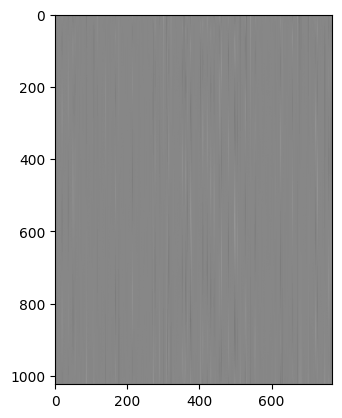

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

The wpe has structure. Each row represent a position and learn the sinusoidal function. We can then add this representation to the embeddings that will help recover the position of the tokens.

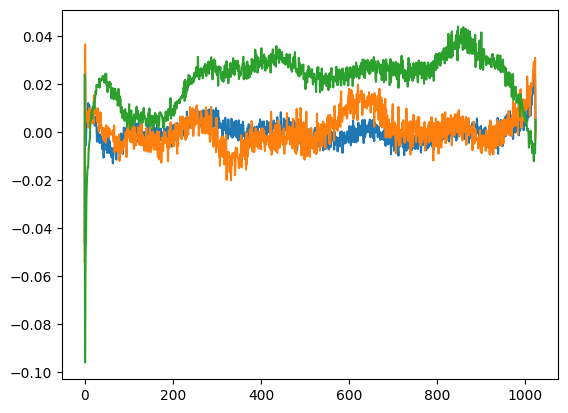

In [7]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

Attention analysis

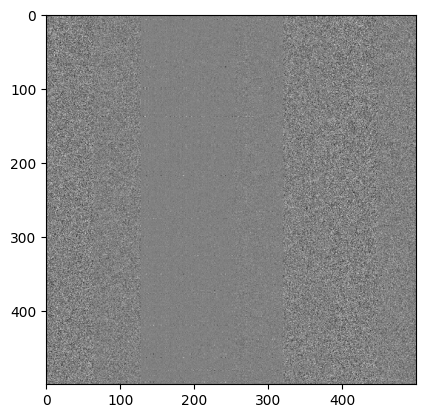

In [8]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:500, :500], cmap="gray")

We see some structure

In [9]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [10]:
# tiny shakespear dataset
data_path = "/home/mathieu/study/andrej/GPT2-from-scratch/data/input.txt"
with open(data_path, "r") as f:
    text = f.read()

data = text[:1000] # first 1000 characters
print(data[:100])

FileNotFoundError: [Errno 2] No such file or directory: '/home/mathieu/study/andrej/GPT2-from-scratch/data/input.txt'

In [ ]:
!wc /home/mathieu/study/andrej/GPT2-from-scratch/data/input.txt

  39999  202651 1115393 /home/mathieu/study/andrej/GPT2-from-scratch/data/input.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1]) # Add +1 to get the next token of the last tokens in the sequence for the labels (B, T+1)
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [ ]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [ ]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

140435591540800
140435591540800


same pointer for the 2 weight matrices

In [ ]:
# standard deviation grows inside the residual stream
x = torch.zeros(768)
x2 = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += torch.randn(768)

print(x.std())

# we add a coeff (n**-0.5) to control the std of the residual to 1
for i in range(n):
    x2 += n**-0.5 * torch.randn(768)

print(x2.std())

tensor(10.2067)
tensor(0.9847)


In [ ]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

tensor([ 0.1168,  0.0503,  0.0012, -0.0884, -0.0271,  0.0317,  0.0084,  0.0824,
         0.1230, -0.0266])


In [ ]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = (y[0] - yhat[0])**2
# L1 = (y[1] - yhat[1])**2
# L2 = (y[2] - yhat[2])**2
# L3 = (y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])

tensor([ 0.1168,  0.0503,  0.0012, -0.0884, -0.0271,  0.0317,  0.0084,  0.0824,
         0.1230, -0.0266])


In [19]:
import torch
t = torch.tensor([[0, 128, 32, 888],
                 [12, 41, 52, 83],
                 [48, 80, 91, 29]], dtype=torch.float)

In [33]:
topk_probs, topk_indices = torch.topk(t, 3, dim=-1)


In [34]:
print(topk_probs)
print(topk_indices)

tensor([[888., 128.,  32.],
        [ 83.,  52.,  41.],
        [ 91.,  80.,  48.]])
tensor([[3, 1, 2],
        [3, 2, 1],
        [2, 1, 0]])


In [35]:
sample_rng = torch.Generator(device="cpu")
sample_rng.manual_seed(42)

In [36]:
ix = torch.multinomial(topk_probs, 1, generator=sample_rng)

In [37]:
ix

tensor([[0],
        [0],
        [1]])

In [38]:
xcol = torch.gather(topk_indices, -1, ix)
print(xcol)

tensor([[3],
        [3],
        [1]])
